In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.
C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pc\AppData\Roaming\Python\

In [2]:
batch_size=32
train_datagen = ImageDataGenerator() 
valid_datagen = ImageDataGenerator() 
test_datagen = ImageDataGenerator() 

train_generator = train_datagen.flow_from_directory(
    directory=r"D:/BACHDataset2/AugSegTrain",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    directory=r"D:/BACHDataset2/SegValidation",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:/BACHDataset2/SegTest",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 1920 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [3]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
import tensorflow as tf
img_rows, img_cols, img_channel = 224, 224, 3

base_model = keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_tensor=None,
    input_shape=(img_rows, img_cols, img_channel), pooling=None)
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

C:\Users\pc\anaconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [5]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(BatchNormalization())
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(BatchNormalization())
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(BatchNormalization())
add_model.add(Dense(64, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(BatchNormalization())
add_model.add(Dense(4, activation='softmax'))


model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [6]:

def init_callbacks():
  from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
  base_path = "D:\\BACHWeights2\\ResNet50AugSeg\\"

 
  trained_models_path = base_path + 'model_weights'
  model_names = trained_models_path + '.{epoch:04d}--{val_loss:.4f}--{val_accuracy:.4f}.h5'
  model_checkpoint = ModelCheckpoint(model_names, monitor = 'val_accuracy', verbose=1,save_best_only=False,save_weights_only=True)

  callbacks = [model_checkpoint]
  return callbacks

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
60/60 [==============================] - 452s 8s/step - loss: 0.7397 - accuracy: 0.6797 - f1_m: 0.2143 - precision_m: 0.2789 - recall_m: 0.1755 - val_loss: 0.5792 - val_accuracy: 0.7578 - val_f1_m: 0.0606 - val_precision_m: 1.0000 - val_recall_m: 0.0312

Epoch 00001: saving model to D:\BACHWeights2\ResNet50AugSeg\model_weights.0001--0.5792--0.7578.h5
Epoch 2/100
60/60 [==============================] - 432s 7s/step - loss: 0.7243 - accuracy: 0.6805 - f1_m: 0.2089 - precision_m: 0.2762 - recall_m: 0.1693 - val_loss: 0.5724 - val_accuracy: 0.7188 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

Epoch 00002: saving model to D:\BACHWeights2\ResNet50AugSeg\model_weights.0002--0.5724--0.7188.h5
Epoch 3/100
60/60 [==============================] - 442s 7s/step - loss: 0.7124 - accuracy: 0.6882 - f1_m: 0.2296 - precision_m: 0.3021 - recall_m: 0.1870 - val_l

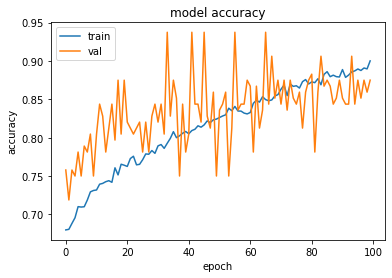

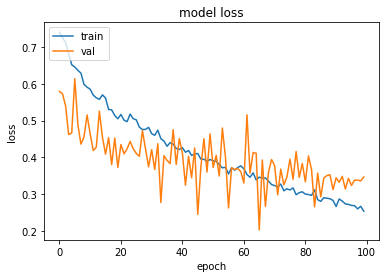

In [7]:
#history = model.fit_generator(batch_size=train_generator.samples // batch_size, generator=train_generator, validation_data= validation_generator, validation_steps=validation_generator.samples // batch_size,epochs=25,callbacks= init_callbacks())

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100,
                    callbacks= init_callbacks()
)


vhistory=model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

print(vhistory)


STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]




#Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_class_indices))
print('Classification Report')
target_names = ['Bengin', 'InSitu', 'Invasive','Normal']
print(classification_report(test_generator.classes, predicted_class_indices, target_names=target_names))


y_test = test_generator.classes[test_generator.index_array]

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted_class_indices)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test,predicted_class_indices,average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test,predicted_class_indices,average='micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,predicted_class_indices,average='micro')
print('F1 score: %f' % f1)



#ROC

# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# n_classes=4
# for i in range(n_classes):
#     fpr, tpr, _ = metrics.roc_curve(test_generator.classes, predicted_class_indices)

#     roc_auc[i] = auc(fpr[i], tpr[i])
# colors = cycle(['blue', 'red', 'green','orange'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic for multi-class data')
# plt.legend(loc="lower right")
# plt.show()





filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("D:\\BACHWeights2\\ResNet50AugSeg\\results.csv",index=False)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model.save("D:\\BACHWeights2\\ResNet50AugSeg\\my_model")